In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import PIL
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from tqdm import tqdm
import tensorflow_addons as tfa
import random
from sklearn.preprocessing import MultiLabelBinarizer
from PIL import Image

pd.set_option("display.max_columns", None)

print('success')

success


### Processing images
#### Example taken from: https://www.kaggle.com/seyunhan/inceptionresnetv2-keras-pbl4

We load the train,test,val images here

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [3]:
train['labels'] = train['labels'].apply(lambda string: string.split(' '))
train

,image,labels
0,800113bb65efe69e.jpg,[healthy]
1,8002cb321f8bfcdf.jpg,"[scab, frog_eye_leaf_spot, complex]"
2,80070f7fb5e2ccaa.jpg,[scab]
3,80077517781fb94f.jpg,[scab]
4,800cbf0ff87721f8.jpg,[complex]
...,...,...
17696,fffb900a92289a33.jpg,[healthy]
17697,fffc488fa4c0e80c.jpg,[scab]
17698,fffc94e092a59086.jpg,[rust]
17699,fffe105cf6808292.jpg,"[scab, frog_eye_leaf_spot]"


Index(['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust',
       'scab'],
      dtype='object')
complex               2029
frog_eye_leaf_spot    4125
healthy               4387
powdery_mildew        1226
rust                  1965
scab                  5442
dtype: int64
['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']


<AxesSubplot:>

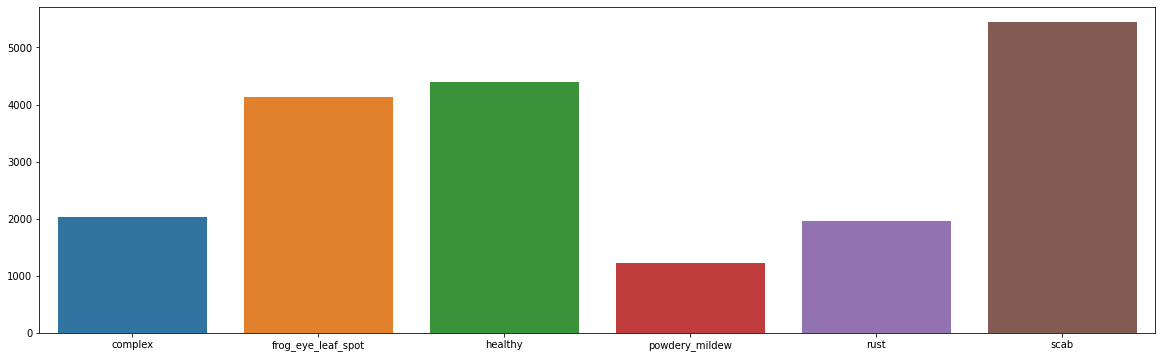

In [4]:
s = list(train['labels'])
mlb = MultiLabelBinarizer()
trainx = pd.DataFrame(mlb.fit_transform(s), columns=mlb.classes_, index=train.index)
print(trainx.columns)
print(trainx.sum())

labels = list(trainx.sum().keys())
print(labels)
label_counts = trainx.sum().values.tolist()

fig, ax = plt.subplots(1,1, figsize=(20,6))

sns.barplot(x= labels, y= label_counts, ax=ax)

### Viewing some images

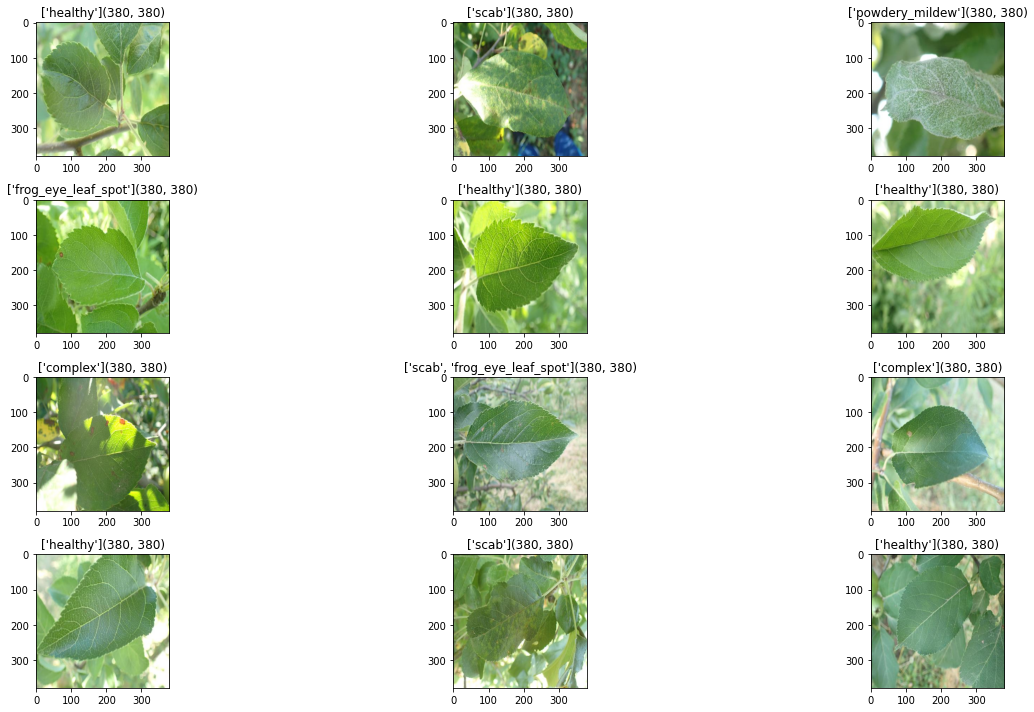

In [5]:
fig1 = plt.figure(figsize=(26,10))

for i in range(1, 13):
    
    rand =  random.randrange(1, len(list(train['image'])))
    sample = os.path.join('./train_images380/', train['image'][rand])
    
    img = Image.open(sample)
    
    ax = fig1.add_subplot(4,3,i)
    ax.imshow(img)
    
    title = f"{train['labels'][rand]}{img.size}"
    plt.title(title)
    
    fig1.tight_layout()

In [10]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1/255.0,
                            rotation_range=5,
                            zoom_range=0.1,
                            shear_range=0.05,
                            horizontal_flip=True,
                            validation_split=0.1)

train_generator = datagen.flow_from_dataframe(
    train,
    directory='./train_images380',
    subset='training',
    x_col='image',
    y_col='labels',
    target_size=(380,380),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=444
    )

#'../input/plant-pathology-2021-fgvc8/train_images'
valid_generator = datagen.flow_from_dataframe(
    train,
    directory='./train_images380',
    subset='validation',
    x_col='image',
    y_col='labels',
    target_size=(380,380),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=444
    )

Found 15931 validated image filenames belonging to 6 classes.
Found 1770 validated image filenames belonging to 6 classes.


In [7]:
import h5py

In [8]:
    import ssl
    ssl._create_default_https_context = ssl._create_unverified_context

In [9]:
# seed = 1200
# tf.random.set_seed(seed)


# weights_path = '../input/keras-pretrained-models/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5'
# model = keras.applications.InceptionResNetV2(weights=weights_path, include_top=False, input_shape=(224, 224, 3))
model = tf.keras.Sequential([
        # keras.layers.Input(shape = (224,224,3)),
        # img_augmentation,
        keras.applications.Xception(input_shape=(380, 380, 3), include_top=False, weights='imagenet'),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(6, kernel_initializer=keras.initializers.RandomUniform(seed=1200),
                           bias_initializer=keras.initializers.Zeros(), name='dense_top', activation='sigmoid')
])


# strategy = tf.distribute.MirroredStrategy()

# with strategy.scope():
#     inputs = keras.layers.Input(shape=(224, 224, 3))
#     x = img_augmentation(inputs)
#     outputs = keras.applications.EfficientNetB0(include_top=True, weights=None, classes=6)(x)

#     model = tf.keras.Model(inputs, outputs)
#     model.compile(
#         optimizer="adam", loss="binary_crossentropy", metrics=["f1_score"]
#     )
for layer in model.layers[:-1]:
    layer.trainable=False


# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
# model.compile(
#     optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
# )

print(model.input)
print(model.output)
model.summary()

2022-03-24 17:05:17.215306: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-24 17:05:17.215407: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

KerasTensor(type_spec=TensorSpec(shape=(None, 380, 380, 3), dtype=tf.float32, name='xception_input'), name='xception_input', description="created by layer 'xception_input'")
KerasTensor(type_spec=TensorSpec(shape=(None, 6), dtype=tf.float32, name=None), name='dense_top/Sigmoid:0', description="created by layer 'dense_top'")
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 12, 12, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization_4 (Batc  (None, 2048)             8192      
 hNormalization)                                 

In [95]:
# new_model = tf.keras.Sequential([
#     model,
#     keras.layers.GlobalAveragePooling2D(),
#     keras.layers.Dense(6, 
#         kernel_initializer=keras.initializers.RandomUniform(seed=seed),
#         bias_initializer=keras.initializers.Zeros(), name='dense_top', activation='sigmoid')
# ])

# # Freezing the weights
# for layer in new_model.layers[:-1]:
#     layer.trainable=False
    
# new_model.summary()

In [ ]:
# tf.config.set_visible_devices([], 'GPU')

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [70]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
print("Num GPUs Available: ", len(physical_devices))
# tf.config.experimental.set_memory_growth(
#     physical_devices[0], enable='True'
# )

# import PIL.Image

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [11]:
# from tensorflow.keras.callbacks import EarlyStopping
import PIL
f1 = tfa.metrics.F1Score(num_classes=6,average='macro')


model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy',f1])
# callbacks = keras.callbacks.EarlyStopping(monitor='f1_score', patience=4, mode='max', restore_best_weights=True)
history = model.fit(train_generator,
                    validation_data=valid_generator,
                    epochs=65,
                    steps_per_epoch=train_generator.samples//256, # = 58
                    validation_steps=valid_generator.samples//128,)
                    # callbacks=callbacks)


Epoch 1/65


2022-03-24 17:10:27.589305: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-24 17:10:28.898419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


62/62 [==============================] - ETA: 0s - loss: 0.4376 - accuracy: 0.3851 - f1_score: 0.2360

2022-03-24 17:11:56.062970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


62/62 [==============================] - 107s 2s/step - loss: 0.4376 - accuracy: 0.3851 - f1_score: 0.2360 - val_loss: 0.3926 - val_accuracy: 0.4231 - val_f1_score: 0.2365
Epoch 2/65
62/62 [==============================] - 107s 2s/step - loss: 0.3723 - accuracy: 0.5060 - f1_score: 0.3779 - val_loss: 0.3535 - val_accuracy: 0.5288 - val_f1_score: 0.4021
Epoch 3/65
62/62 [==============================] - 112s 2s/step - loss: 0.3460 - accuracy: 0.5595 - f1_score: 0.4631 - val_loss: 0.3428 - val_accuracy: 0.5481 - val_f1_score: 0.4973
Epoch 4/65
62/62 [==============================] - 116s 2s/step - loss: 0.3297 - accuracy: 0.5761 - f1_score: 0.5114 - val_loss: 0.3257 - val_accuracy: 0.5865 - val_f1_score: 0.5150
Epoch 5/65
62/62 [==============================] - 118s 2s/step - loss: 0.3211 - accuracy: 0.5867 - f1_score: 0.5224 - val_loss: 0.3119 - val_accuracy: 0.6202 - val_f1_score: 0.5360
Epoch 6/65
62/62 [==============================] - 116s 2s/step - loss: 0.3106 - accuracy: 0.60

In [17]:
# test_data = datagen.flow_from_dataframe(
#     test,
#     directory = './test_size256_images',
#     x_col="image",
#     y_col= None,
#     color_mode="rgb",
#     target_size = (256,256),
#     classes=None,
#     class_mode=None,
#     batch_size=32,
#     shuffle=False,
#     seed=40,
# )

test_data = datagen.flow_from_dataframe(
    test,
    directory = './test_images380',
    x_col="image",
    y_col= None,
    color_mode="rgb",
    target_size = (380,380),
    classes=None,
    class_mode=None,
    batch_size=32,
    shuffle=False,
    seed=40,
)

# train_generator = datagen.flow_from_dataframe(
#     train,
#     directory='./train_images',
#     subset='training',
#     x_col='image',
#     y_col='labels',
#     target_size=(224,224),
#     color_mode='rgb',
#     class_mode='categorical',
#     batch_size=64,
#     shuffle=True,
#     seed=444
#     )


preds = model.predict(test_data)
print(preds)
preds = preds.tolist()

# {0: 'complex', 1: 'frog_eye_leaf_spot', 2: 'healthy', 3: 'powdery_mildew', 4: 'rust', 5: 'scab'}
threshold = {0: 0.26, # Complex
             5: 0.61, # scab
             1: 0.7, # frog eye leaf spot
             4: 0.5, # rust
             3: 0.5, # powdery mildew
             2: 0.3} #healthy

             
# Can set different threshold here
indices = []
for pred in preds:
    temp = []
    for category in pred:
        if category>=threshold[pred.index(category)]: #assigning a different threshold to each disease
            temp.append(pred.index(category))
    if temp!=[]:
        pass
    else:
        temp.append(np.argmax(pred))
    # only add the predicted healthy labels, remove others
    if 2 in temp:
        temp = [2] # Resets the list 
    indices.append(temp)
    
print(indices[:10])

Found 931 validated image filenames.
[[5.40969186e-02 1.67174749e-02 9.84777451e-01 1.27154915e-02
  1.29657900e-02 6.46410137e-02]
 [1.03630781e-01 9.80180681e-01 2.21491300e-05 1.48007926e-03
  8.24375004e-02 4.92022820e-02]
 [1.21215090e-01 1.90889724e-02 1.19034550e-03 6.59796655e-01
  4.22090925e-02 3.81017804e-01]
 ...
 [1.93270117e-01 7.60202169e-01 3.28381010e-03 1.43741537e-02
  1.55546851e-02 5.03225923e-01]
 [1.23486053e-02 1.04428381e-01 8.49630356e-01 6.95547275e-03
  8.41767993e-03 2.22725496e-01]
 [1.22137435e-01 1.62180871e-01 1.82620875e-04 3.37144220e-03
  2.02525303e-01 6.70334518e-01]]
[[2], [1], [3], [0, 1], [5], [0, 4], [2], [0, 1], [5], [5]]


In [18]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

testlabels = []


for image in indices:
    temp = []
    for i in image:
        temp.append(str(labels[i]))
    testlabels.append(' '.join(temp))

print(testlabels[:10])

{0: 'complex', 1: 'frog_eye_leaf_spot', 2: 'healthy', 3: 'powdery_mildew', 4: 'rust', 5: 'scab'}
['healthy', 'frog_eye_leaf_spot', 'powdery_mildew', 'complex frog_eye_leaf_spot', 'scab', 'complex rust', 'healthy', 'complex frog_eye_leaf_spot', 'scab', 'scab']


In [19]:
actuallabels = list(test['labels'])
print(actuallabels[:10])

['healthy', 'frog_eye_leaf_spot', 'powdery_mildew', 'frog_eye_leaf_spot', 'scab', 'rust', 'healthy', 'frog_eye_leaf_spot', 'scab', 'scab']


In [20]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(actuallabels,testlabels)
print(f"Test accuracy score: {accuracy}")

Test accuracy score: 0.6638023630504833


In [22]:
actual_test = pd.read_csv('sample_submission.csv')

In [23]:
for img_name in tqdm(actual_test['image']):
    path = './actual_test_images/'+str(img_name)
    with PIL.Image.open(path) as img:
        img = img.resize((380,380))
        img.save(f'./actual_test_images/{img_name}')

100%|██████████| 3/3 [00:00<00:00,  7.02it/s]


In [27]:
actual_test_data = datagen.flow_from_dataframe(
    actual_test,
    directory = './actual_test_images',
    x_col="image",
    y_col= None,
    color_mode="rgb",
    target_size = (380,380),
    classes=None,
    class_mode=None,
    batch_size=32,
    shuffle=False,
    seed=40,
)

actual_preds = model.predict(actual_test_data)
print(actual_preds)
actual_preds = actual_preds.tolist()

# {0: 'complex', 1: 'frog_eye_leaf_spot', 2: 'healthy', 3: 'powdery_mildew', 4: 'rust', 5: 'scab'}
threshold = {0: 0.26, # Complex
             5: 0.61, # scab
             1: 0.7, # frog eye leaf spot
             4: 0.5, # rust
             3: 0.5, # powdery mildew
             2: 0.3} #healthy

             
# Can set different threshold here
indices = []
for pred in actual_preds:
    temp = []
    for category in pred:
        if category>=threshold[pred.index(category)]: #assigning a different threshold to each disease
            temp.append(pred.index(category))
    if temp!=[]:
        pass
    else:
        temp.append(np.argmax(pred))
    # only add the predicted healthy labels, remove others
    if 2 in temp:
        temp = [2] # Resets the list 
    indices.append(temp)
    
print(indices)

Found 3 validated image filenames.
[[1.9621009e-01 7.3040321e-02 5.7062330e-03 1.6944525e-03 3.8941747e-01
  2.2720981e-01]
 [3.5628393e-01 4.8327756e-01 3.5647460e-04 1.8445604e-02 4.6679765e-02
  4.7978419e-01]
 [2.4877246e-01 8.0423391e-01 1.4508875e-03 1.4599737e-03 7.5845107e-02
  1.2536637e-01]]
[[4], [0], [1]]


In [28]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

actualtestlabels = []


for image in indices:
    temp = []
    for i in image:
        temp.append(str(labels[i]))
    actualtestlabels.append(' '.join(temp))

print(actualtestlabels)

{0: 'complex', 1: 'frog_eye_leaf_spot', 2: 'healthy', 3: 'powdery_mildew', 4: 'rust', 5: 'scab'}
['rust', 'complex', 'frog_eye_leaf_spot']


In [29]:
sub = pd.read_csv('./sample_submission.csv')
sub['labels'] = actualtestlabels
sub.to_csv('submission.csv', index=False)
sub

,image,labels
0,85f8cb619c66b863.jpg,rust
1,ad8770db05586b59.jpg,complex
2,c7b03e718489f3ca.jpg,frog_eye_leaf_spot
